# MICHAEL JORDAN VS LEBRON JAMES
## Utilizing regression analysis to compare both players and determine who is the best NBA star

Marc Martín (NIU - 1564274), Marina Vázquez (NIU - 1563735), Mireia Fernández (NIU - 1562636)

### TABLE OF CONTENTS
***

1. Imports
1. Preprocessing: Data Cleaning
1. Implemented functions: Utilities
1. Split and Standardization
1. Visualization: Gaussian like attributes and Targets
1. Visualization of the Covariance Matrices
1. Simple Linear Regressions (only 1 attribute)
1. Multivariate Regressions with all the attributes
1. Polynomial fit: 2nd degree
1. Polynomial fit: 3nd degree
1. Principal Component Analysis
1. Gradient Descent

***

### 1. IMPORTS
***

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import axes3d, Axes3D

sns.set(style="darkgrid")
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 2. PREPROCESSING: DATA CLEANING
***

In [2]:
jordan = pd.read_csv("jordan_career.csv")
lebron = pd.read_csv("lebron_career.csv")

pd.set_option('display.max_rows', jordan.shape[0] + 1)
pd.set_option('display.max_rows', lebron.shape[0] + 1)
pd.set_option('display.max_columns', jordan.shape[1] + 1)
pd.set_option('display.max_columns', lebron.shape[1] + 1)

jordan.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 
lebron.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 

jordan["threep"] = jordan["threep"].fillna(0)
lebron["threep"] = lebron["threep"].fillna(0)

jordan["ftp"] = jordan["ftp"].fillna(0)
lebron["ftp"] = lebron["ftp"].fillna(0)

jordan["result"] = [int(res.split(" ")[1][1:-1]) for res in jordan["result"]]
lebron["result"] = [int(res.split(" ")[1][1:-1]) for res in lebron["result"]]

t_age = lambda a, b: a + b / 365
jordan["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in jordan["age"]]
lebron["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in lebron["age"]]

t_time = lambda a, b: a + b / 60
jordan["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in jordan["mp"]]
lebron["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in lebron["mp"]]

### 3. IMPLEMENTED FUNCTIONS: UTILITIES
***

In [3]:
all_attributes = ["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]


def mse(v1, v2):
    return ((v1 - v2)**2).mean()


def print_info_regr_test(regressor, X_test, y_test):
    print('Testing R2 Score:', regressor.score(X_test, y_test))
    print('Testing MSE:', np.mean((regressor.predict(X_test) - y_test)**2))
    

def print_info_regr_train_cv(regressor, X_train, y_train, X_cv, y_cv):
    print('\nCoefs (per dim):', regressor.coef_, 'and intercept:', regressor.intercept_)
    print('\nTraining R2 Score:', regressor.score(X_train, y_train))
    print('Cross validation R2 Score:', regressor.score(X_cv, y_cv))
    print('\nTraining MSE:', np.mean((regressor.predict(X_train) - y_train)**2))
    print('Cross validation MSE:', np.mean((regressor.predict(X_cv) - y_cv)**2))
    
    
def round_lst(lst, decimals):
    return [round(num, decimals) for num in lst]


def split_df(x, s1=0.6, s2=0.8):
    size = x.shape[0]
    return x[:int(size * s1)], x[int(size * s1):int(size * s2)], x[int(size * s2):]


def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    return (x_train - mean[None, :]) / std[None, :]

### 4. SPLIT AND STANDARDIZATION
***

In [4]:
X_jordan = jordan[all_attributes]
y_jordan = jordan["game_score"]
X_lebron = lebron[all_attributes]
y_lebron = lebron["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)

js = standarize(jordan)
ls = standarize(lebron)

### 5. VISUALIZATION OF THE DATA: 
***


#### GAUSSIAN LIKE ATTRIBUTES

Text(0.5, 0.98, "Jordan's attributes with Gaussian like distributions")

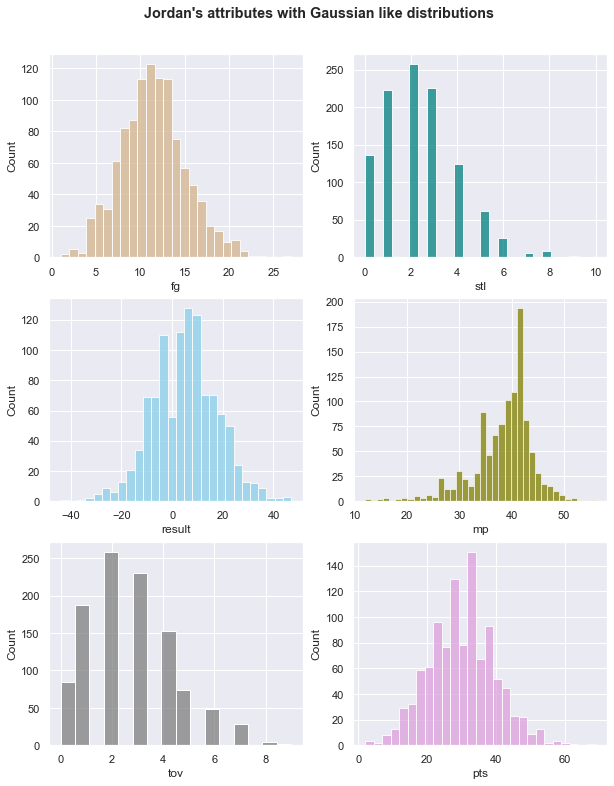

In [5]:
#histograms with gaussian like attributes jordan

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(top=0.925)
sns.histplot(data=jordan, x="result", color="skyblue", ax=axs[1, 0])
sns.histplot(data=jordan, x="mp", color="olive", ax=axs[1, 1])
sns.histplot(data=jordan, x="fg", color="tan", ax=axs[0, 0])
sns.histplot(data=jordan, x="stl", color="teal", ax=axs[0, 1])
sns.histplot(data=jordan, x="tov", color="gray", ax=axs[2, 0])
sns.histplot(data=jordan, x="pts", color="plum", ax=axs[2, 1])

fig.suptitle("Jordan's attributes with Gaussian like distributions",
             fontsize = 'x-large', fontweight = 'bold' )

#plt.savefig("distributions_j.png", dpi = 300, bbox_inches = 'tight')

Text(0.5, 0.98, "Lebron's attributes with Gaussian like distributions")

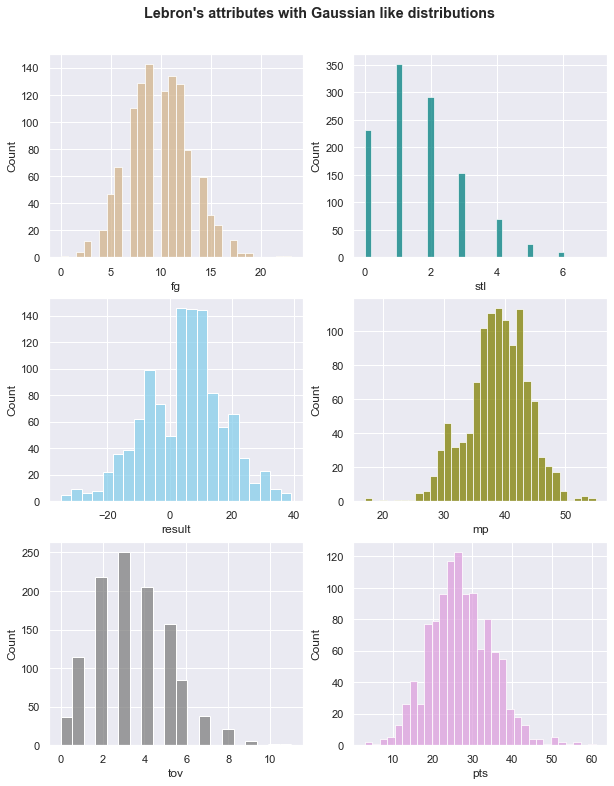

In [6]:
#histograms with gaussian like attributes lebron

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(top=0.925)
sns.histplot(data=lebron, x="result", color="skyblue", ax=axs[1, 0])
sns.histplot(data=lebron, x="mp", color="olive", ax=axs[1, 1])
sns.histplot(data=lebron, x="fg", color="tan", ax=axs[0, 0])
sns.histplot(data=lebron, x="stl", color="teal", ax=axs[0, 1])
sns.histplot(data=lebron, x="tov", color="gray", ax=axs[2, 0])
sns.histplot(data=lebron, x="pts", color="plum", ax=axs[2, 1])

fig.suptitle("Lebron's attributes with Gaussian like distributions",
             fontsize = 'x-large', fontweight = 'bold' )

#plt.savefig("distributions_l.png", dpi = 300, bbox_inches = 'tight')

#### TARGET ATTRIBUTES

Text(0, 0.5, 'Amount of Games')

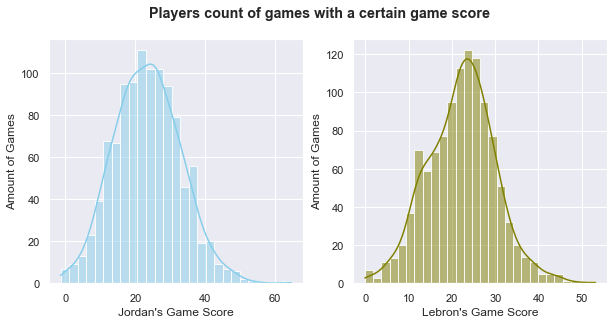

In [7]:
#game_score histograms
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

sns.histplot(data=jordan, x="game_score", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=lebron, x="game_score", kde=True, color="olive", ax=axs[1])

fig.suptitle("Players count of games with a certain game score",
             fontsize = 'x-large', fontweight = 'bold' )
axs[0].set_xlabel("Jordan\'s Game Score")
axs[0].set_ylabel("Amount of Games")
axs[1].set_xlabel("Lebron\'s Game Score")
axs[1].set_ylabel("Amount of Games")

Text(0, 0.5, 'Amount of Games')

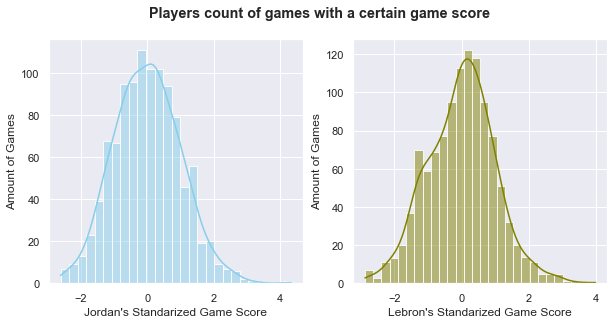

In [8]:
#game_score standarized histograms
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))

sns.histplot(data=js, x="game_score", kde=True, color="skyblue", ax=axs[0])
sns.histplot(data=ls, x="game_score", kde=True, color="olive", ax=axs[1])

fig.suptitle("Players count of games with a certain game score",
             fontsize = 'x-large', fontweight = 'bold' )
axs[0].set_xlabel("Jordan\'s Standarized Game Score")
axs[0].set_ylabel("Amount of Games")
axs[1].set_xlabel("Lebron\'s Standarized Game Score")
axs[1].set_ylabel("Amount of Games")

### 6. VISUALIZATION OF THE COVARIANCE MATRICES
***

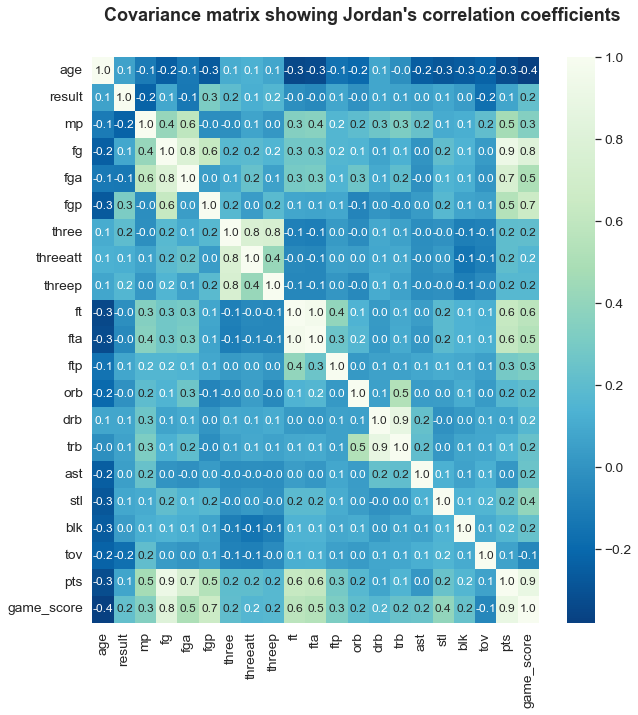

In [9]:
#jordans heatmap

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(jordan.corr(), cbar=True, annot=True, square=False, fmt='.1f', cmap="GnBu_r", 
                 annot_kws={'size': 12}, yticklabels=list(jordan), xticklabels=list(jordan))

plt.subplots_adjust(top=0.91)
plt.suptitle('Covariance matrix showing Jordan\'s correlation coefficients', fontsize = 'large', fontweight = 'bold')

plt.show()

#plt.savefig("hm_jordan.png", dpi = 300, bbox_inches = 'tight')

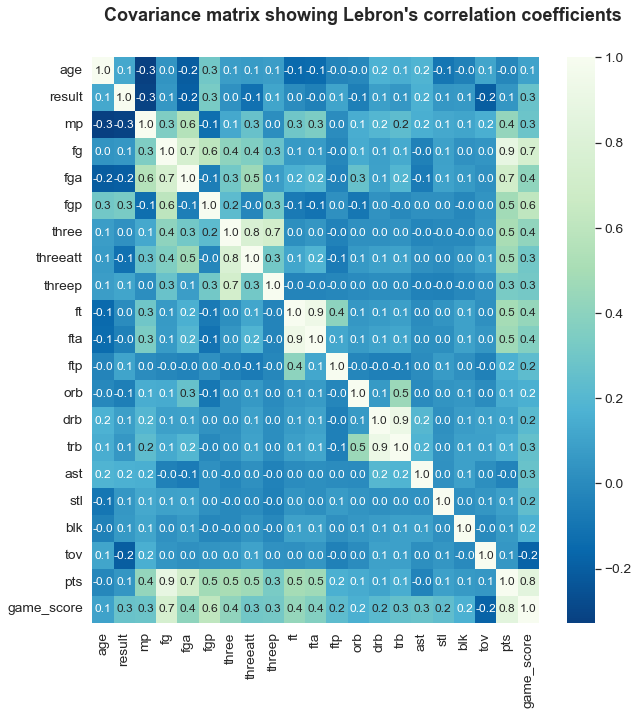

In [10]:
#lebrons heatmap

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(lebron.corr(), cbar=True, annot=True, square=False, fmt='.1f', cmap="GnBu_r", 
                 annot_kws={'size': 12}, yticklabels=list(jordan), xticklabels=list(jordan))

plt.subplots_adjust(top=0.91)
plt.suptitle('Covariance matrix showing Lebron\'s correlation coefficients', fontsize = 'large', fontweight = 'bold')

plt.show()

#plt.savefig("hm_lebron.png", dpi = 300, bbox_inches = 'tight')

### 7. SIMPLE LINEAR REGRESSIONS WITH ONE ATTRIBUTE 
***

#### MICHAEL JORDAN

In [11]:
y_j = js["game_score"]

regr = LinearRegression()
predictions_j = []
MSE_j = []
r2_j = []

for at in all_attributes:
    attribute_j = js[at].values.reshape(js.shape[0], 1)
    regr.fit(attribute_j, y_j)
    predictions_j.append(regr.predict(attribute_j))

for pred in predictions_j:
    MSE_j.append(mse(y_j, pred))
    r2_j.append(r2_score(y_j, pred))

print("Mean squeared error: ", MSE_j)
print("R2 score: ", r2_j)

Mean squeared error:  [0.8550817372885056, 0.9492526185454523, 0.8792564640088111, 0.34449340597285627, 0.7431720402603865, 0.5637520480378435, 0.9551591353609895, 0.9725312629851134, 0.9687155031729304, 0.6696396231555409, 0.7112903609603588, 0.8971273133295353, 0.9566308100425838, 0.9714828081367018, 0.9414759924801329, 0.9375920745117609, 0.8414519469787471, 0.9449743642372292, 0.9956987904504638, 0.19710941055257755]
R2 score:  [0.14411986706509994, 0.04986105781444927, 0.11992256823767922, 0.6551849381858993, 0.2561340549401184, 0.4357215728323358, 0.04394902604390327, 0.026560677945806854, 0.03038000055893575, 0.32973512976401564, 0.28804550238141513, 0.10203503278313564, 0.04247597724962715, 0.02761011174365735, 0.05764494496853256, 0.06153248937758504, 0.15776238360297334, 0.05414330675788048, 0.003371518802150364, 0.8027065470472801]


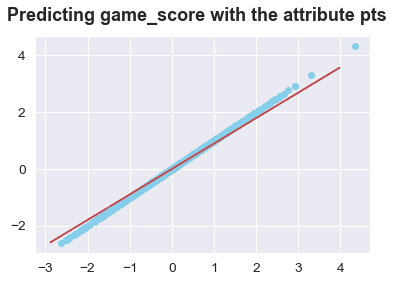

In [12]:
#best mse gotten with attribute pts (3.2.1)
fig = plt.figure()
plt.suptitle('Predicting game_score with the attribute pts', fontsize = 'large', fontweight = 'bold')
ax = plt.scatter(js["game_score"], y_j, color = "skyblue")
pts = js[all_attributes[19]].values.reshape(js.shape[0], 1)

plt.plot(pts[:,0], predictions_j[19], 'r')
#plt.savefig("gsj_pts.png", dpi = 300, bbox_inches = 'tight')

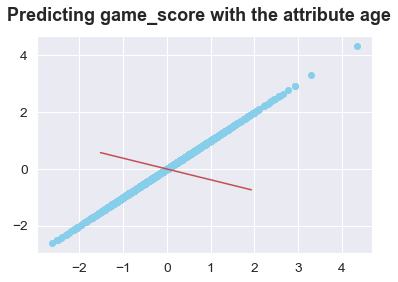

In [13]:
#worst mse gotten with attribute years (3.2.1)
fig = plt.figure()
plt.suptitle('Predicting game_score with the attribute age', fontsize = 'large', fontweight = 'bold')
ax = plt.scatter(js["game_score"], y_j, color = "skyblue")
age = js[all_attributes[0]].values.reshape(js.shape[0], 1)

plt.plot(age[:,0], predictions_j[0], 'r')
#plt.savefig("gsj_age.png", dpi = 300, bbox_inches = 'tight')

#### LEBRON JAMES

In [14]:
y_l = ls["game_score"]

regr = LinearRegression()
predictions_l = []
MSE_l = []
r2_l = []

for at in all_attributes:
    attribute_l = ls[at].values.reshape(ls.shape[0], 1)
    regr.fit(attribute_l, y_l)
    predictions_l.append(regr.predict(attribute_l))

for pred in predictions_l:
    MSE_l.append(mse(y_l, pred))
    r2_l.append(r2_score(y_l, pred))

print("Mean squeared error:", MSE_l)
print("R2 score:", r2_l)

Mean squeared error: [0.9889197904232003, 0.9260061477335992, 0.9195944799513003, 0.4483812175511008, 0.8310334643172256, 0.6260712793514422, 0.8236539839565951, 0.9071448866801878, 0.9011867511961745, 0.8130871423399292, 0.8647490877196193, 0.944954316575775, 0.9740755804869963, 0.9532286931365458, 0.934712645388159, 0.9246719410121056, 0.9419363045619767, 0.9729833652920331, 0.9674456320873327, 0.28333550718381173]
R2 score: [0.010205833104276918, 0.07317510235682212, 0.07959243916456937, 0.5512223357490312, 0.16823175808390878, 0.373375165140732, 0.17561776318402622, 0.0920530400336228, 0.09801644354193895, 0.1861939477198954, 0.1344863242275779, 0.05421018004971101, 0.02506316789453622, 0.04592848750612599, 0.06446090664951687, 0.0745104887482747, 0.05723086050914461, 0.026156348797011897, 0.03169897831754187, 0.7164139751263707]


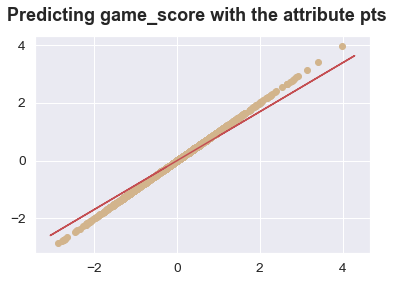

In [15]:
#best mse gotten with attribute pts (3.2.2)
fig = plt.figure()
plt.suptitle('Predicting game_score with the attribute pts', fontsize = 'large', fontweight = 'bold')
ax = plt.scatter(ls["game_score"], y_l, color = "tan")
pts = ls[all_attributes[19]].values.reshape(ls.shape[0], 1)

plt.plot(pts[:,0], predictions_l[19], 'r')

#plt.savefig("gsl_pts.png", dpi = 300, bbox_inches = 'tight')

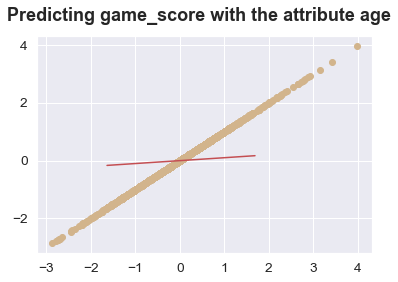

In [16]:
#worst mse gotten with attribute years (3.2.2)
fig = plt.figure()
plt.suptitle('Predicting game_score with the attribute age', fontsize = 'large', fontweight = 'bold')
ax = plt.scatter(ls["game_score"], y_l, color = "tan")
age = ls[all_attributes[0]].values.reshape(ls.shape[0], 1)

plt.plot(age[:,0], predictions_l[0], 'r')

#plt.savefig("gsl_age.png", dpi = 300, bbox_inches = 'tight')

### 8. MULTIVARIATE REGRESSORS WITH ALL THE ATTRIBUTES
***

#### MICHAEL JORDAN (Standardized)

In [17]:
X_train_js, X_test_js, X_cross_js = split_df(js[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]])
y_train_js, y_test_js, y_cross_js = split_df(js["game_score"])

regr_js = LinearRegression()
regr_js.fit(X_train_js, y_train_js) 

print_info_regr_test(regr_js, X_test_js, y_test_js)
print_info_regr_train_cv(regr_js, X_train_js, y_train_js, X_cross_js, y_cross_js)

Testing R2 Score: 0.9963052176912673
Testing MSE: 0.0026931527806955792

Coefs (per dim): [ 0.02585891  0.00427128 -0.01662072  0.54424216 -0.45785169 -0.02135976
  0.05889714 -0.01256416 -0.00721604  0.34692122 -0.18676634  0.0041181
  0.07877961  0.02931342  0.06264126  0.20067048  0.17640849  0.07722873
 -0.18492842  0.57787105] and intercept: 0.0056220844554413785

Training R2 Score: 0.9967889565452203
Cross validation R2 Score: 0.9951397943608495

Training MSE: 0.0028271591442169744
Cross validation MSE: 0.003873698594460874


MICHAEL JORDAN (Non Standardized)

In [18]:
# for section 3.3
regr_jordan = LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)
print('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
print('\nTesting R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))


Coefs (per dim)  [ 0.04581011  0.00316263 -0.02762215  0.34371023 -0.73175504 -1.86309188
  0.07300259 -0.06799796 -0.22033934  0.30467866 -0.38266728  0.18582104
  0.37499931 -0.03488572  0.34011358  0.69922455  1.01041767  0.72456767
 -1.01206531  1.06510171]  and intercept:  -0.5616354678546358

Training Score: 0.9967889565452203
Testing Score: 0.9963052176912673

Training MSE:  0.2544597185359226
Testing MSE:  0.2423984160749604

Testing R2 score:  0.9963052176912673


Text(0, 0.5, 'Predicted game_score')

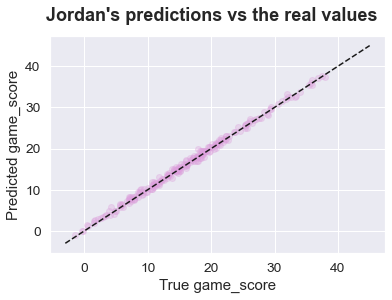

In [19]:
# Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)

fig = plt.figure()
plt.suptitle('Jordan\'s predictions vs the real values', fontsize = 'large', fontweight = 'bold')

plt.scatter(y_cross_j, predicted, alpha=0.3, color="plum")
plt.plot([-3, 45], [-3, 45], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("pred_vs_real.png", dpi = 300, bbox_inches = 'tight')

##### LEBRON JAMES (Standardized)

In [20]:
X_train_ls, X_test_ls, X_cross_ls = split_df(ls[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]])
y_train_ls, y_test_ls, y_cross_ls = split_df(ls["game_score"])

regr_ls = LinearRegression()
regr_ls.fit(X_train_ls, y_train_ls) 

print_info_regr_test(regr_ls, X_test_ls, y_test_ls)
print_info_regr_train_cv(regr_ls, X_train_ls, y_train_ls, X_cross_ls, y_cross_ls)

Testing R2 Score: 0.9954132723346405
Testing MSE: 0.0038455583174864566

Coefs (per dim): [ 6.50578722e-03  6.11738862e-04 -4.86104071e-03  5.04582342e-01
 -4.39524642e-01 -1.14165287e-03  7.19995008e-02  2.07822750e-03
  3.01279480e-03  3.75953163e-01 -2.28150096e-01 -1.02390414e-04
  8.12598652e-02  4.22671714e-02  6.97951397e-02  2.61216455e-01
  1.67619375e-01  8.45625838e-02 -2.44272584e-01  5.73728195e-01] and intercept: 0.0019757716782303064

Training R2 Score: 0.9962333972806781
Cross validation R2 Score: 0.9948837067317874

Training MSE: 0.004237097026837371
Cross validation MSE: 0.003995406165818038


#### LEBRON JAMES (Non Standardized)

In [21]:
# for section 3.3
regr_le = LinearRegression()
regr_le.fit(X_train_l, y_train_l) 

print('\nCoefs (per dim) ', regr_le.coef_, ' and intercept: ', regr_le.intercept_)
print('\nTraining Score:', regr_le.score(X_train_l, y_train_l) )
print('Testing Score:', regr_le.score(X_test_l, y_test_l) )
print('\nTraining MSE: ', np.mean((regr_le.predict(X_train_l) - y_train_l)**2))
print('Testing MSE: ', np.mean((regr_le.predict(X_test_l) - y_test_l)**2))
print('\nTesting R2 score: ', r2_score(y_test_l, regr_le.predict(X_test_l)))


Coefs (per dim)  [ 1.17163081e-02  3.68018072e-04 -7.49322108e-03  3.48127029e-01
 -7.03409263e-01 -7.79448289e-02 -5.84432123e-02  6.90145526e-03
  9.19804063e-02  3.88994305e-01 -4.21185397e-01 -4.00334723e-03
  3.75885498e-01 -3.61065719e-02  3.39778926e-01  7.06484830e-01
  9.93857592e-01  7.12659727e-01 -1.03748551e+00  1.02680515e+00]  and intercept:  -0.5401998904075072

Training Score: 0.9962333972806781
Testing Score: 0.9954132723346405

Training MSE:  0.25717803084140406
Testing MSE:  0.23341290258702174

Testing R2 score:  0.9954132723346405


Text(0, 0.5, 'Predicted game_score')

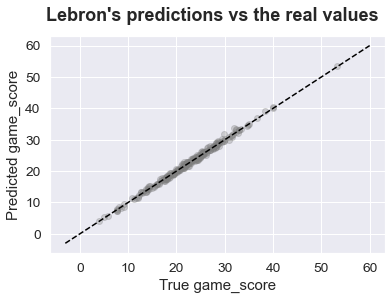

In [22]:
# Visualization of target and predicted responses
clf = LinearRegression()
clf.fit(X_train_l, y_train_l)
predicted = clf.predict(X_cross_l)

fig = plt.figure()
plt.suptitle('Lebron\'s predictions vs the real values', fontsize = 'large', fontweight = 'bold')

plt.scatter(y_cross_l, predicted, alpha=0.3, color="gray")
plt.plot([-3, 60], [-3, 60], '--k', color = "black")
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("pred_vs_real_l.png", dpi = 300, bbox_inches = 'tight')

### 9. POLYNOMIAL FIT: SECOND DEGREE
***

#### MICHAEL JORDAN

In [23]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train_j)
poly_reg.fit(X_poly,y_train_j)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_j)
predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_j))
print('\nCross Validation R2: ', r2_score(y_cross_j, predicted))

predicted2 = lin_reg2.predict(poly_reg.fit_transform(X_test_j))
print('\nTest R2: ', r2_score(y_test_j, predicted2))


Cross Validation R2:  0.9754513244482171

Test R2:  0.9909606595437579


Text(0, 0.5, 'Predicted game_score')

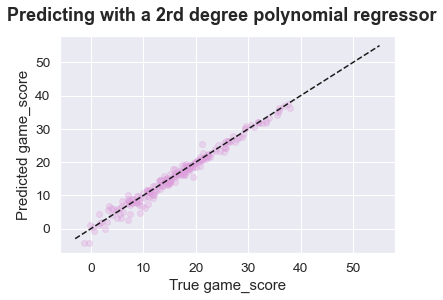

In [24]:
fig = plt.figure()

plt.suptitle('Predicting with a 2rd degree polynomial regressor', fontsize = 'large', fontweight = 'bold')
plt.plot([-3, 55], [-3, 55], '--k')
plt.scatter(y_cross_j, predicted, alpha=0.3, color = "plum")
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("2poly_c_j_bo.png", dpi = 300, bbox_inches = 'tight')

#### LEBRON JAMES

In [25]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train_l)
poly_reg.fit(X_poly,y_train_l)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_l)

predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_l))
print('\nCross Validation R2: ', r2_score(y_cross_l, predicted))

predicted2 = lin_reg2.predict(poly_reg.fit_transform(X_test_l))
print('\nTest R2: ', r2_score(y_test_l, predicted2))


Cross Validation R2:  0.9657720143234856

Test R2:  0.9887692284364242


Text(0, 0.5, 'Predicted game_score')

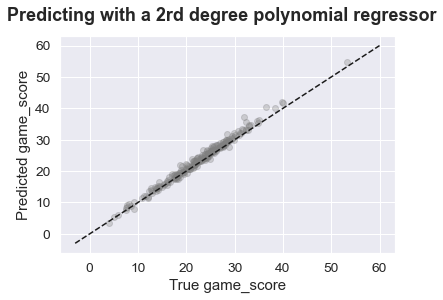

In [26]:
fig = plt.figure()

plt.suptitle('Predicting with a 2rd degree polynomial regressor', fontsize = 'large', fontweight = 'bold')
plt.plot([-3, 60], [-3, 60], '--k')
plt.scatter(y_cross_l, predicted, alpha=0.3, color = "gray")
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("2poly_c_l.png", dpi = 300, bbox_inches = 'tight')

### 10. POLYNOMIAL FIT: THIRD DEGREE
***

#### MICHAEL JORDAN

In [27]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_j)
poly_reg.fit(X_poly,y_train_j)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_j)
predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_j))
print('\nCross Validation R2: ', r2_score(y_cross_j, predicted))

predicted2 = lin_reg2.predict(poly_reg.fit_transform(X_test_j))
print('\nTest R2: ', r2_score(y_test_j, predicted2))


Cross Validation R2:  0.3659743391035266

Test R2:  0.592655399002967


Text(0, 0.5, 'Predicted game_score')

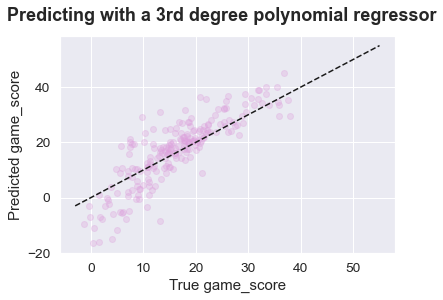

In [28]:
fig = plt.figure()

plt.suptitle('Predicting with a 3rd degree polynomial regressor', fontsize = 'large', fontweight = 'bold')
plt.plot([-3, 55], [-3, 55], '--k')
plt.scatter(y_cross_j, predicted, alpha=0.3, color = "plum")
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("poly_c_j_bo.png", dpi = 300, bbox_inches = 'tight')

#### LEBRON JAMES

In [29]:
#fitting the polynomial regression model to the dataset
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_l)
poly_reg.fit(X_poly,y_train_l)

lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y_train_l)
predicted = lin_reg2.predict(poly_reg.fit_transform(X_cross_l))
print('\nCross Validation R2: ', r2_score(y_cross_l, predicted))

predicted2 = lin_reg2.predict(poly_reg.fit_transform(X_test_l))
print('\nTest R2: ', r2_score(y_test_l, predicted2))


Cross Validation R2:  0.22970925355440508

Test R2:  0.7014835971476936


Text(0, 0.5, 'Predicted game_score')

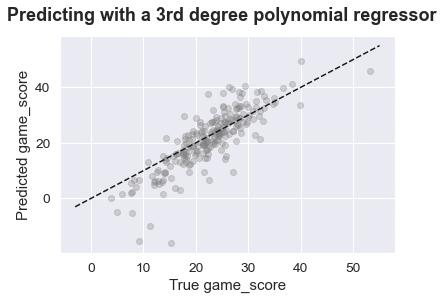

In [30]:
fig = plt.figure()

plt.suptitle('Predicting with a 3rd degree polynomial regressor', fontsize = 'large', fontweight = 'bold')
plt.plot([-3, 55], [-3, 55], '--k')
plt.scatter(y_cross_l, predicted, alpha=0.3, color = "gray")
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

#plt.savefig("poly_c_l_bo.png", dpi = 300, bbox_inches = 'tight')

### 11. PRINCIPAL COMPONENT ANALYSIS
***

#### MICHAEL JORDAN

In [31]:
# inicialization of the data that will be used
X_jordan = js[all_attributes]
y_jordan = js["game_score"]

X_train_j, X_test_j, _ = split_df(X_jordan, 0.5, 1)
y_train_j, y_test_j, _ = split_df(y_jordan, 0.5, 1)

In [32]:
# creates a pca model
pca_best = PCA()
x_train = pca_best.fit_transform(X_train_j)
x_test = pca_best.transform(X_test_j)

linear_model = LinearRegression()
linear_model.fit(x_train, y_train_j)
preds = linear_model.predict(x_test)

mse_pca = mean_squared_error(y_test_j, preds)
r2_pca = r2_score(y_test_j, preds)

#information of the best pca 
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")
print("Test R2:",r2_pca)
print("Test MSE:",mse_pca)

Best PCA obtained with 20 components
Test R2: 0.9967510464525927
Test MSE: 0.0028880768409781836


In [33]:
#collection of scores for n components
mses, r2s = [], []
for n_components in np.arange(X_train_j.shape[1]) + 1:
    pca = PCA(n_components)
    
    x_train = pca.fit_transform(X_train_j)
    x_test = pca.transform(X_test_j)
    linear_model = LinearRegression()
    linear_model.fit(x_train, y_train_j)
    preds = linear_model.predict(x_test)

    mse_pca = mean_squared_error(y_test_j, preds)
    r2_pca = r2_score(y_test_j, preds)
    
    mses.append(mse_pca)
    r2s.append(r2_pca)

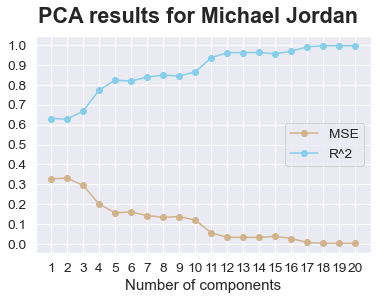

In [34]:
fig = plt.figure()

plt.suptitle('PCA results for Michael Jordan', fontsize = 'x-large', fontweight = 'bold')
plt.plot(mses, "o-", label="MSE", color="tan")
plt.plot(r2s, "o-", label="R^2",color="skyblue")
plt.xticks(np.arange(X_train_j.shape[1]), np.arange(1, X_train_j.shape[1] + 1))
plt.yticks(np.arange(11) * 0.1)
plt.axis('tight')
plt.xlabel('Number of components')

plt.legend()
plt.savefig("pca_bo_j.png", dpi = 300, bbox_inches = 'tight') 
plt.show()

#### LEBRON JAMES

In [35]:
# inicialization of the data that will be used
X_lebron = ls[all_attributes]
y_lebron = ls["game_score"]

X_train_l, X_test_l, _ = split_df(X_lebron, 0.5, 1)
y_train_l, y_test_l, _ = split_df(y_lebron, 0.5, 1)

In [36]:
# creates a pca model
pca_best = PCA()
x_train = pca_best.fit_transform(X_train_l)
x_test = pca_best.transform(X_test_l)

linear_model = LinearRegression()
linear_model.fit(x_train, y_train_l)
preds = linear_model.predict(x_test)

mse_pca = mean_squared_error(y_test_l, preds)
r2_pca = r2_score(y_test_l, preds)

#information of the best pca 
print(f"Best PCA obtained with {len(pca_best.singular_values_)} components")
print("Test R2:",r2_pca)
print("Test MSE:",mse_pca)

Best PCA obtained with 20 components
Test R2: 0.9951817774512642
Test MSE: 0.003988239562774806


In [37]:
#collection of scores for n components
mses, r2s = [], []
for n_components in np.arange(X_train_l.shape[1]) + 1:
    pca = PCA(n_components)
    
    x_train = pca.fit_transform(X_train_l)
    x_test = pca.transform(X_test_l)
    linear_model = LinearRegression()
    linear_model.fit(x_train, y_train_l)
    preds = linear_model.predict(x_test)

    mse_pca = mean_squared_error(y_test_l, preds)
    r2_pca = r2_score(y_test_l, preds)
    
    mses.append(mse_pca)
    r2s.append(r2_pca)

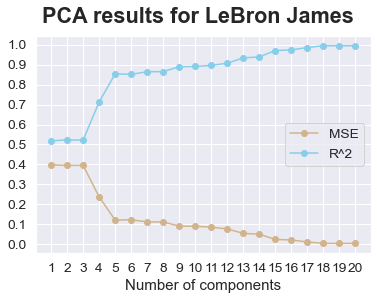

In [38]:
fig = plt.figure()

plt.suptitle('PCA results for LeBron James', fontsize = 'x-large', fontweight = 'bold')
plt.plot(mses, "o-", label="MSE", color="tan")
plt.plot(r2s, "o-", label="R^2", color="skyblue")
#plt.axvline(x=len(pca_best.singular_values_), color="gray", linestyle="--", label="var=0.95")
plt.xticks(np.arange(X_train_l.shape[1]), np.arange(1, X_train_l.shape[1] + 1))
plt.yticks(np.arange(11) * 0.1)
plt.axis('tight')
plt.xlabel('Number of components')

plt.legend()
plt.savefig("pca_bo_l.png", dpi = 300, bbox_inches = 'tight')
plt.show()

### 12. GRADIENT DESCENT
***


In [39]:
class Regressor(object):
    def __init__(self, weights, alpha, beta):
        # Initialize the weights and the previous weights used in the train function
        self.prev = np.array(weights)
        self.weights = np.array(weights)
        # Initialize the specifications for the training process
        self.a = alpha
        self.b = beta

    
    def __J(self, X, y):
        # Function that calculates the MSE (Minimum Square Error) 
        return 0.5 * (np.sum((self.predict(X) - y)**2) + self.b * np.sum(self.weights**2)) / X.shape[0]
    
    
    def __update(self, X, hy, y):
        # Procedure that updates the weights given a matrix, the predicction (hy)  
        # and its real value using a formula that modifies each weight separately
        m = X.shape[0]
        self.weights[0] -= self.a * np.sum(hy - y) / m
        # Except for the weight of the intercept, the other ones must be calculated
        # taking into account the predictions and their real values
        for j in range(1, len(self.weights)):
            self.weights[j] -= self.a * (sum([(hy[i] - y.iloc[i]) * X.iloc[i, j-1] for i in range(m)]) - self.b * self.prev[j]) / m 
    
    
    def predict(self, X):
        # Function that uses the weights to predict an output given a matrix of values
        return [self.weights[0] + np.dot(row, self.weights[1:]) for i, row in X.iterrows()]
        
    
    def train(self, max_iters, eps, X, y):
        # Procedure that trains the Regressor while the improvement is lesser than
        # the parameter given and it has not reached a maximum of iterations
        iters = 0
        improvement = self.__J(X, y)
        last_improvement = 0
        while abs(improvement - last_improvement) > eps and improvement < 10**6 and iters < max_iters:
            # Saves the previous weights and updates the Regressor
            self.prev = np.copy(self.weights)
            self.__update(X, self.predict(X), y)
            # Calculates the new improvment and increases the number of iterations
            last_improvement = improvement
            improvement = self.__J(X, y)
            iters += 1

#### MICHAEL JORDAN

In [40]:
X_jordan = js[all_attributes]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

weights = [0.0056220844554413785, 0.02585891, 0.00427128, -0.01662072, 0.54424216, -0.45785169, -0.02135976,
           0.05889714, -0.01256416, -0.00721604, 0.34692122, -0.18676634, 0.0041181, 0.07877961, 0.02931342,
           0.06264126, 0.20067048, 0.17640849, 0.07722873, -0.18492842, 0.57787105]
weights = round_lst(weights, 1)

In [41]:
values = [0] + [10**i for i in range(-2, 3)]
best_mse, best_alpha, best_beta = np.inf, 0, 0
mses_j = np.zeros((len(values), len(values)))

iters, eps = 40, 0.001
for i, alpha in enumerate(values):
    for j, beta in enumerate(values):
        descens = Regressor(weights, alpha, beta)
        descens.train(iters, eps, X_train_j, y_train_j)
        preds = descens.predict(X_test_j)
        mses_j[i][j] = mean_squared_error(y_test_j, preds)
        if mses_j[i][j] < best_mse:
            best_alpha = alpha
            best_beta = beta
            best_mse = mses_j[i][j]

print("Best alpha:", best_alpha, "\nBest lambda:", best_beta, "\nBest MSE:", best_mse)

Best alpha: 0.1 
Best lambda: 0 
Best MSE: 0.008150506458009762


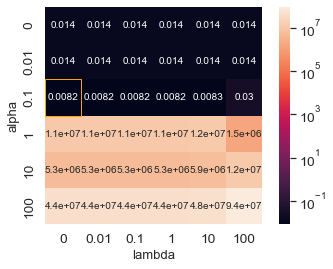

In [42]:
fig = plt.figure()
ax = sns.heatmap(mses_j, square=True, norm=LogNorm(), annot=True, annot_kws={"size":10}, xticklabels=values, yticklabels=values)
ax.add_patch(Rectangle((0, 2), 1, 1, fill=False, edgecolor='orange', lw=1))
plt.xlabel("lambda", fontsize=13)
plt.ylabel("alpha", fontsize=13)
plt.savefig("mse_heatmap_j.eps")
plt.show()

In [43]:
%%timeit
descens = Regressor(weights, best_alpha, best_beta)
descens.train(iters, eps, X_train_j, y_train_j)
descens.predict(X_test_j)

896 ms ± 8.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.8035863977040025


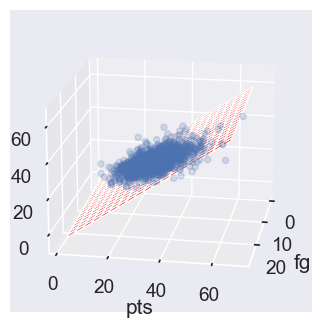

In [44]:
x_val = jordan[["fg", "pts"]]
y_val = jordan["game_score"]
regr = LinearRegression()
regr.fit(x_val, y_val)
predX3D = regr.predict(x_val)
print(r2_score(y_val, predX3D))

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0], 1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 = malla * (max(x_val.iloc[:,0]) - min(x_val.iloc[:,0]))/2 + min(x_val.iloc[:,0])
malla_x2 = malla * (max(x_val.iloc[:,1]) - min(x_val.iloc[:,1]))/2 + min(x_val.iloc[:,1])

xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot, yplot, zplot, color='red', alpha=0.9)
plt3d.scatter(x_val.iloc[:,0], x_val.iloc[:,1], y_val, alpha=0.2)
plt.xlabel("fg")
plt.ylabel("pts")
plt3d.view_init(18, 10)
plt.savefig("jordan_3d.jpeg")
plt.show()

#### LEBRON JAMES

In [45]:
X_lebron = ls[all_attributes]
y_lebron = ls["game_score"]

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)

weights = [0.0019757716782303064, 6.50578722e-03, 6.11738862e-04, -4.86104071e-03, 5.04582342e-01, -4.39524642e-01, -1.14165287e-03,
           7.19995008e-02, 2.07822750e-03, 3.01279480e-03, 3.75953163e-01, -2.28150096e-01, -1.02390414e-04, 8.12598652e-02,
           4.22671714e-02, 6.97951397e-02, 2.61216455e-01, 1.67619375e-01, 8.45625838e-02, -2.44272584e-01, 5.73728195e-01]
weights = round_lst(weights, 1)

In [46]:
values = [0] + [10**i for i in range(-2, 3)]
best_mse, best_alpha, best_beta = np.inf, 0, 0
mses_l = np.zeros((len(values), len(values)))

iters, eps = 40, 0.001
for i, alpha in enumerate(values):
    for j, beta in enumerate(values):
        descens = Regressor(weights, alpha, beta)
        descens.train(iters, eps, X_train_l, y_train_l)
        preds = descens.predict(X_test_l)
        mses_l[i][j] = mean_squared_error(y_test_l, preds)
        if mses_j[i][j] < best_mse:
            best_alpha = alpha
            best_beta = beta
            best_mse = mses_l[i][j]

print("Best alpha:", best_alpha, "\nBest lambda:", best_beta, "\nBest MSE:", best_mse)

Best alpha: 0.1 
Best lambda: 0 
Best MSE: 0.007515817120954395


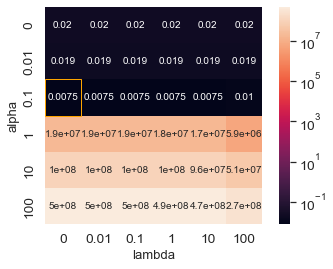

In [47]:
fig = plt.figure()
ax = sns.heatmap(mses_l, square=True, norm=LogNorm(), annot=True, annot_kws={"size":10}, xticklabels=values, yticklabels=values)
ax.add_patch(Rectangle((0, 2), 1, 1, fill=False, edgecolor='orange', lw=1))
plt.xlabel("lambda", fontsize=13)
plt.ylabel("alpha", fontsize=13)
plt.savefig("mse_heatmap_l.eps")
plt.show()

In [48]:
%%timeit
descens = Regressor(weights, best_alpha, best_beta)
descens.train(iters, eps, X_train_l, y_train_l)
descens.predict(X_test_l)

1.47 s ± 85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.7166534672858456


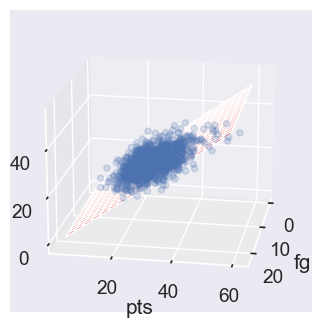

In [49]:
x_val = lebron[["fg", "pts"]]
y_val = lebron["game_score"]
regr = LinearRegression()
regr.fit(x_val, y_val)
predX3D = regr.predict(x_val)
print(r2_score(y_val, predX3D))

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0], 1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 = malla * (max(x_val.iloc[:,0]) - min(x_val.iloc[:,0]))/2 + min(x_val.iloc[:,0])
malla_x2 = malla * (max(x_val.iloc[:,1]) - min(x_val.iloc[:,1]))/2 + min(x_val.iloc[:,1])

xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot, yplot, zplot, color='red', alpha=0.9)
plt3d.scatter(x_val.iloc[:,0], x_val.iloc[:,1], y_val, alpha=0.2)
plt.xlabel("fg")
plt.ylabel("pts")
plt3d.view_init(18, 10)
plt.savefig("lebron_3d.jpeg")
plt.show()